In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
from sklearn.utils import class_weight
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import (
    recall_precision_fscore_from_confusion_matrix
)

from labelsUtils import (
    Label,
)

from regionUtils import (
    vietnam_labels_coordinates,
)

from rasterUtils import (
    make_dataset_from_raster_files,
)

from convNetUtils import (
    cross_validation,
    plot_confusion_matrix,
    separate_data_into_images_and_labels,
    evaluate_model,
    compute_class_weights,
    images_from_dataset,
    labels_from_dataset,
    train_model,
    AUGMENTATIONS,
    LandsatSequence,
)

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    TIRS1 = 7
    TIRS2 = 8
    NDVI = 9
    MNDWI = 10
    EVI2 = 11
    BU = 12

In [3]:
EPOCHS = 500
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [4]:
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

In [5]:
NB_PIXEL_AROUND=4

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2018_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [7]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2019_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [8]:
labels_names = [label.name for label in labels]
nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

model_name = "january_to_april_2018"

# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

model.summary()

# Specify optimizer and loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

In [9]:
# Create train sets
X_train = images_from_dataset(dataset_2018, bands)
y_train = labels_from_dataset(dataset_2018, labels_names)
Y_train = to_categorical(y_train, num_classes=len(labels_names))

# Create test sets
X_test = images_from_dataset(dataset_2019, bands)
y_test = labels_from_dataset(dataset_2019, labels_names)
Y_test = to_categorical(y_test, num_classes=len(labels_names))

In [10]:
# create data generators
train_datagen = LandsatSequence(X_train, Y_train, batch_size=32, augmentations=AUGMENTATIONS)

class_weights = compute_class_weights(y_train)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=class_weights,
    epochs=EPOCHS,
    steps_per_epoch=len(y_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
290/290 [==============================] - 1s 3ms/step - loss: 1.1923 - accuracy: 0.3846
Epoch 2/500
290/290 [==============================] - 1s 3ms/step - loss: 0.9591 - accuracy: 0.5090
Epoch 3/500
290/290 [==============================] - 1s 3ms/step - loss: 0.8820 - accuracy: 0.5598
Epoch 4/500
290/290 [==============================] - 1s 3ms/step - loss: 0.8171 - accuracy: 0.5973
Epoch 5/500
290/290 [==============================] - 1s 3ms/step - loss: 0.7931 - accuracy: 0.6197
Epoch 6/500
290/290 [==============================] - 1s 3ms/step - loss: 0.7625 - accuracy: 0.6361
Epoch 7/500
290/290 [==============================] - 1s 3ms/step - loss: 0.7202 - accuracy: 0.6605
Epoch 8/500
290/290 [==============================] - 1s 3ms/step - loss: 0.6999 - accuracy: 0.6722
Epoch 9/500
290/290 [==============================] -

290/290 [==============================] - 1s 4ms/step - loss: 0.3227 - accuracy: 0.8312
Epoch 78/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3371 - accuracy: 0.8312
Epoch 79/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3154 - accuracy: 0.8354
Epoch 80/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3104 - accuracy: 0.8371
Epoch 81/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3206 - accuracy: 0.8357
Epoch 82/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3319 - accuracy: 0.8266
Epoch 83/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3454 - accuracy: 0.8232
Epoch 84/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3223 - accuracy: 0.8313
Epoch 85/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3107 - accuracy: 0.8318
Epoch 86/500
290/290 [==============================] - 1s 4ms/step - loss: 0.3163 - accuracy: 

290/290 [==============================] - 1s 4ms/step - loss: 0.2726 - accuracy: 0.8520
Epoch 157/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2679 - accuracy: 0.8539
Epoch 158/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2730 - accuracy: 0.8511
Epoch 159/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2672 - accuracy: 0.8570
Epoch 160/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2857 - accuracy: 0.8501
Epoch 161/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2707 - accuracy: 0.8526
Epoch 162/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2598 - accuracy: 0.8561
Epoch 163/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2620 - accuracy: 0.8648
Epoch 164/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2742 - accuracy: 0.8537
Epoch 165/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2728 - a

290/290 [==============================] - 1s 4ms/step - loss: 0.2407 - accuracy: 0.8651
Epoch 236/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2386 - accuracy: 0.8673
Epoch 237/500
290/290 [==============================] - 1s 5ms/step - loss: 0.2158 - accuracy: 0.8721
Epoch 238/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2296 - accuracy: 0.8734
Epoch 239/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2584 - accuracy: 0.8667
Epoch 240/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2441 - accuracy: 0.8655
Epoch 241/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2312 - accuracy: 0.8703
Epoch 242/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2195 - accuracy: 0.8777
Epoch 243/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2341 - accuracy: 0.8725
Epoch 244/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2444 - a

290/290 [==============================] - 1s 4ms/step - loss: 0.2409 - accuracy: 0.8780
Epoch 315/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2134 - accuracy: 0.8808
Epoch 316/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2199 - accuracy: 0.8797
Epoch 317/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2145 - accuracy: 0.8761
Epoch 318/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2135 - accuracy: 0.8755
Epoch 319/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2172 - accuracy: 0.8807
Epoch 320/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2309 - accuracy: 0.8804
Epoch 321/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2123 - accuracy: 0.8808
Epoch 322/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2088 - accuracy: 0.8832
Epoch 323/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2163 - a

290/290 [==============================] - 1s 4ms/step - loss: 0.2096 - accuracy: 0.8868
Epoch 394/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2000 - accuracy: 0.8910
Epoch 395/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2125 - accuracy: 0.8877
Epoch 396/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2065 - accuracy: 0.8942
Epoch 397/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2033 - accuracy: 0.8879
Epoch 398/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1958 - accuracy: 0.8926
Epoch 399/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2196 - accuracy: 0.8834
Epoch 400/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2012 - accuracy: 0.8882
Epoch 401/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2090 - accuracy: 0.8865
Epoch 402/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2194 - a

290/290 [==============================] - 1s 5ms/step - loss: 0.2014 - accuracy: 0.8920
Epoch 473/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1962 - accuracy: 0.8903
Epoch 474/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2327 - accuracy: 0.8847
Epoch 475/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1927 - accuracy: 0.8934
Epoch 476/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2008 - accuracy: 0.8903
Epoch 477/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1962 - accuracy: 0.8947
Epoch 478/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1836 - accuracy: 0.8987
Epoch 479/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1870 - accuracy: 0.8999
Epoch 480/500
290/290 [==============================] - 1s 4ms/step - loss: 0.2407 - accuracy: 0.8818
Epoch 481/500
290/290 [==============================] - 1s 4ms/step - loss: 0.1973 - a

In [11]:
conf_matrix, accuracy, loss = evaluate_model(trained_model, X_test, Y_test, y_test, len(labels_names))

In [12]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.6727412343025208
accuracy:  0.8091241717338562


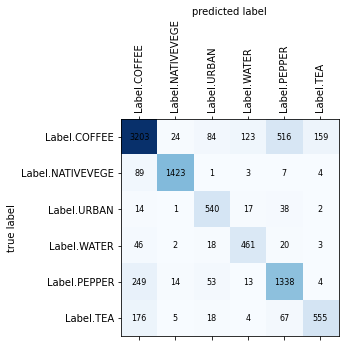

In [13]:
plot_confusion_matrix(conf_matrix, labels)

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.84802754 0.96868618 0.75630252 0.74235105 0.67371601 0.76341128]
Mean precision:  0.7920824291963156

Recalls:  [0.7795084  0.9318926  0.88235294 0.83818182 0.80071813 0.67272727]
Mean recall:  0.8175635268354365

F-Score:  [0.81232564 0.94993324 0.81447964 0.78736123 0.73174733 0.71520619]
Mean f-score:  0.8018422119792659
